# Correlation analysis between the Bitcoin currency and Twitter

This project consists of a correlation analysis between the Bitcoin currency and tweets. In order to define the positiveness of a tweet (if the course of the bitcoin will go up or down), we realise a sentiment analysis of each tweet using the VADER algorithm. Finally we try to find a correlation between the two and we will make some machine learning to make predictions.

This notebook was written using Python 3.6.

## Import the Python dependencies
For this project we need Pandas to manage all of our datasets.

You will need to run the following commands with pip to install the dependencies:

```
pip install VaderSentiment
pip install pandas
pip install tqdm
...
```

You can also run `pip install .` from the project's root folder to install all the requirements from the `requirements.txt` file.

In [86]:
import json
import pandas as pd
import io
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime, timedelta

## Set the currency and the data files

In [87]:
# Define the currency
#CURRENCY = "zilliqa"
#CURRENCY_SYMBOL = "ZIL"
#CURRENCY = "nexo"
#CURRENCY_SYMBOL = "NEXO"
CURRENCY = "bitcoin"
CURRENCY_SYMBOL = "BTC"

CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
TWITTER_FOLDER = f"data/twitter/{CURRENCY_SYMBOL}"

tweets_clean_file = f'{TWITTER_FOLDER}/{CURRENCY}_tweets_clean.csv'

## Load the datasets

We read the data generated from two other notebooks, TwitterExtraction and CryptoCurrencyExtraction. The extraction process is detailed in these notebooks so please refer to them for any information needed. Here we simply gather all the extracted data to generate two datasets :

- The twitter dataset : contains historical tweets related to the targeted crypto currency with a sentiment score.
- The crypo dataset : contains historical data of the crypto currency we target with the change in USD.

### Twitter dataset

The data is split into multiple files. Here it is gathered into a single dataframe.

In [88]:
#tweets = pd.read_csv(tweets_clean_file)
twitter_files = glob.glob(f"{TWITTER_FOLDER}/*~*.csv")
twitter_files = sorted(twitter_files)

dfs = []
for file in twitter_files:
    dfs.append(pd.read_csv(file))
tweets = pd.concat(dfs)
#tweets = tweets.sort_values(by=['ID'])

# Drop duplicate tweets
print('tweet shape before droping duplicates', tweets.shape)
duplicates_removed = tweets.shape[0]
tweets = tweets.drop_duplicates(subset=['ID'])
duplicates_removed -= tweets.shape[0]
print('tweet shape after droping duplicates', tweets.shape)
print('duplicates removed', duplicates_removed)

# Display dataframes head
tweets.head(2)

tweet shape before droping duplicates (3992, 9)
tweet shape after droping duplicates (989, 9)
duplicates removed 3003


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,score
0,1359452740607332354,RT : We continued to work with global industry...,jejes🐰🐰,83,942,0,Wed Feb 10 10:42:45 +0000 2021,0.0000,0.0000
4,1359452756755402754,Ideaology has listed on Uniswap! $IDEA /wcEisv...,Rakib Shakot,546,0,0,Wed Feb 10 10:42:49 +0000 2021,0.2714,148.4558


### Crypto dataset

In [89]:
CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
crypto_files = glob.glob(f"{CRYPTO_FOLDER}/*.csv")
dfs = []
files = crypto_files
dfs.append(pd.read_csv(files[2], usecols=['time', 'high', 'low', 'open', 'close']))
crypto_usd = pd.concat(dfs)
crypto_usd = crypto_usd.sort_values(by=['time'])

# Drop duplicates
print('bitcoin shape before droping duplicates', crypto_usd.shape)
duplicates_removed = crypto_usd.shape[0]
crypto_usd = crypto_usd.drop_duplicates(subset=['time'])
print('bitcoin shape after droping duplicates', crypto_usd.shape)
duplicates_removed -= crypto_usd.shape[0]
print('duplicates removed', duplicates_removed)
crypto_usd.head(2)

bitcoin shape before droping duplicates (2020, 5)
bitcoin shape after droping duplicates (2001, 5)
duplicates removed 19


,time,high,low,open,close
0,1612861800,46976.51,46876.46,46878.36,46973.14
1,1612861860,47011.15,46968.74,46973.14,46968.74


In [90]:
tweets = tweets.iloc[:-2]

## Group by and sum by timeframe

In [104]:
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'])
tweets.index = tweets['CreatedAt']

tweets_grouped = tweets.groupby(pd.Grouper(freq='30min'))['score'].sum()

crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='s')
crypto_usd.index = crypto_usd['time']

crypto_usd_grouped = crypto_usd.groupby(pd.Grouper(freq='30min'))['close'].mean()
crypto_usd_grouped.tz_localize('UTC')

time
2021-02-09 09:00:00+00:00    46975.904500
2021-02-09 09:30:00+00:00    46477.809333
2021-02-09 10:00:00+00:00    46327.941333
2021-02-09 10:30:00+00:00    46185.974000
2021-02-09 11:00:00+00:00    45985.490667
                                 ...     
2021-02-10 16:30:00+00:00    44643.331667
2021-02-10 17:00:00+00:00    44651.821000
2021-02-10 17:30:00+00:00    45004.489667
2021-02-10 18:00:00+00:00    45117.793667
2021-02-10 18:30:00+00:00    45112.780000
Freq: 30T, Name: close, Length: 68, dtype: float64

In [113]:
crypto_usd_grouped

time
2021-02-10 10:30:00    46785.992
Freq: 30T, Name: close, dtype: float64

In [106]:
tweets_grouped

CreatedAt
2021-02-10 10:30:00+00:00    1.849796e+06
Freq: 30T, Name: score, dtype: float64

### Plotting the scores
We calculate the mean of each tweets grouped by hour and then we plot it.

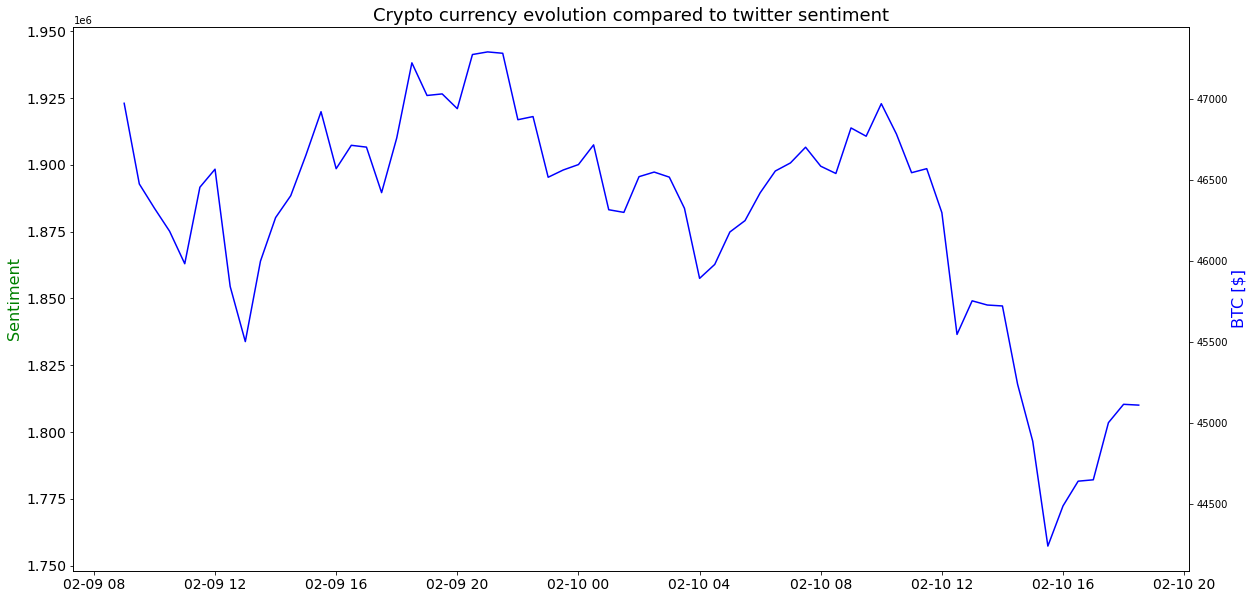

In [107]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} [$]", color='b', fontsize=16)
plt.show()

In [108]:
tweets_grouped

CreatedAt
2021-02-10 10:30:00+00:00    1.849796e+06
Freq: 30T, Name: score, dtype: float64

## Correlation analysis
Here we make the correlation analysis between BTC/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series.
https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [109]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

### Crop the time series to match the time frames

In [110]:
beggining = max(tweets_grouped.index.min(), crypto_usd_grouped.tz_localize('UTC').index.min())
end = min(tweets_grouped.index.max(), crypto_usd_grouped.tz_localize('UTC').index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

In [111]:
beggining

Timestamp('2021-02-10 10:30:00+0000', tz='UTC', freq='30T')

In [112]:
end

Timestamp('2021-02-10 10:30:00+0000', tz='UTC', freq='30T')

CreatedAt
2021-02-10 10:30:00+00:00    1.849796e+06
Freq: 30T, Name: score, dtype: float64

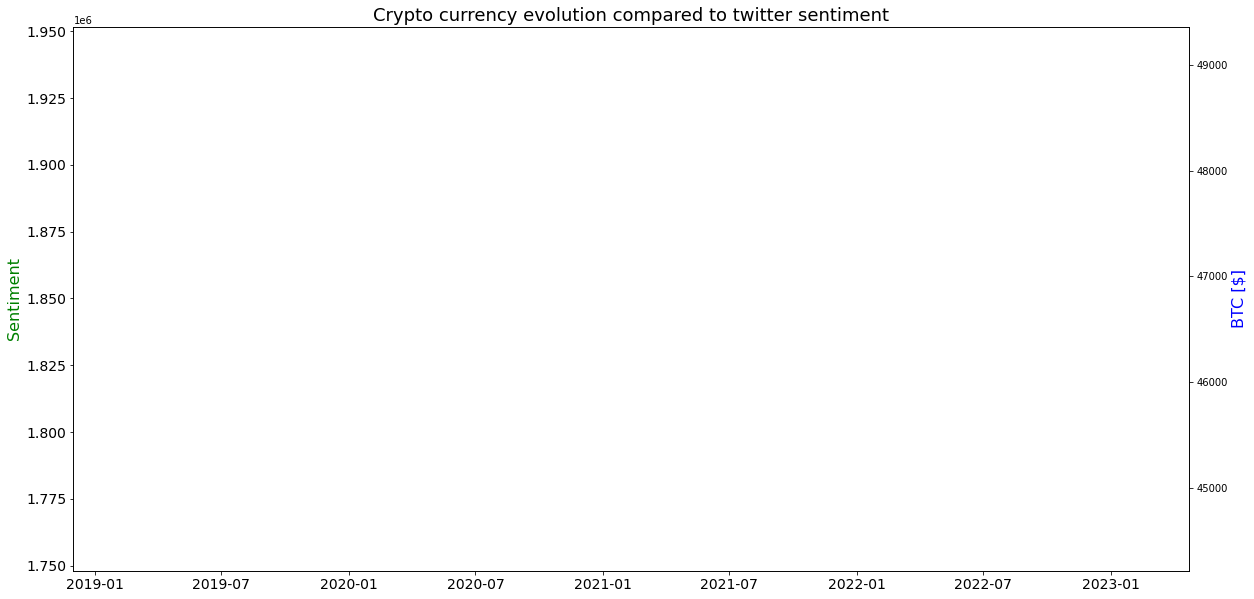

In [114]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index.tz_localize('UTC'), crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} [$]", color='b', fontsize=16)
plt.show()

/home/ayush/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ayush/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


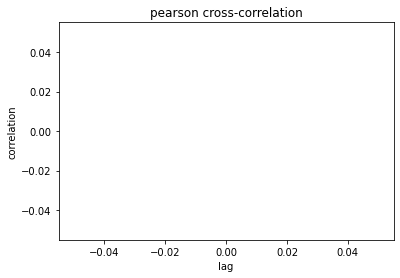

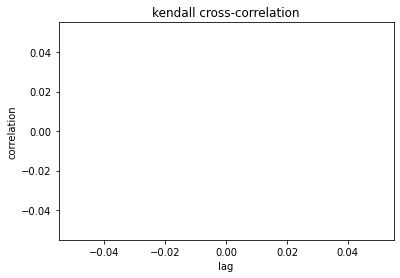

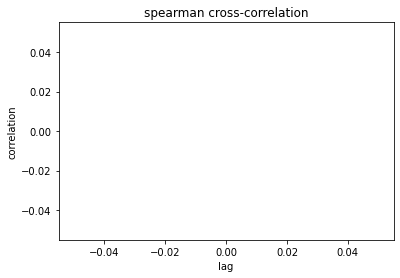

In [116]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped.tz_localize('UTC'), lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped.tz_localize('UTC'), lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped.tz_localize('UTC'), lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize 
First we need to normalize the data.

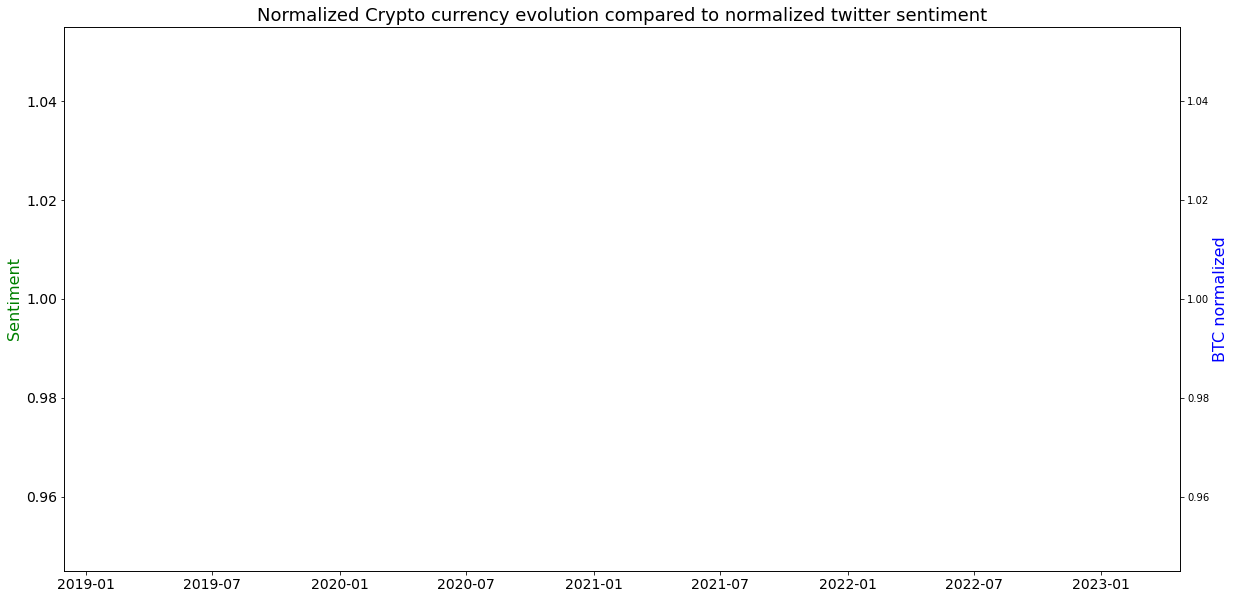

In [117]:
# Normalize time series data
tweets_grouped = tweets_grouped / max(tweets_grouped.max(), abs(tweets_grouped.min()))
crypto_usd_grouped = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL} normalized", color='b', fontsize=16)
plt.show()

/home/ayush/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ayush/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


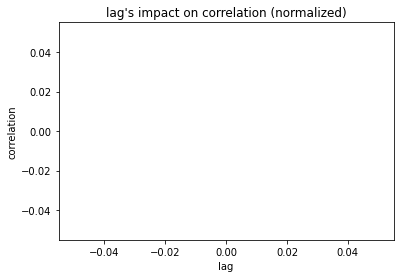

In [119]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped.tz_localize('UTC'), lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Calculate derivative

The derivative is calculated to define an increase or a decrease of the crypto currency.

The score is as well derivated to observe the increase or decrease of the score.

Computing the derivative could help to find a correlation.

In [120]:
# Derivative
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

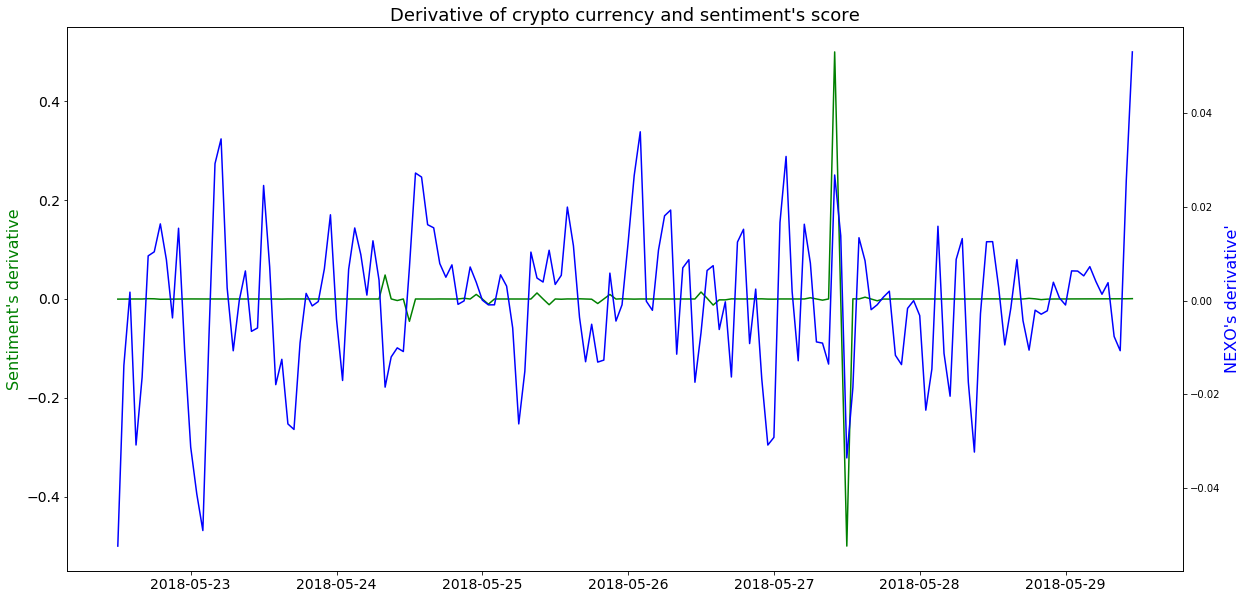

In [164]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL}'s derivative'", color='b', fontsize=16)
plt.show()

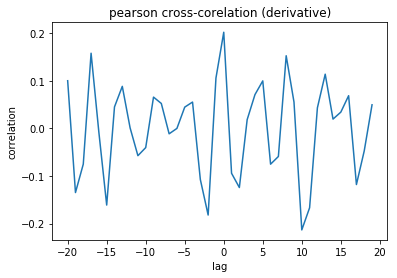

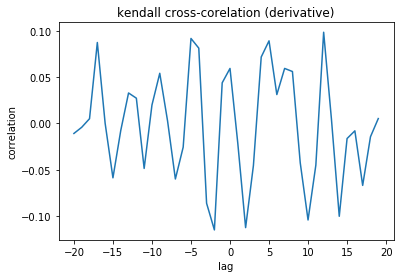

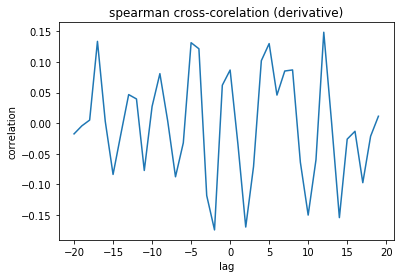

In [165]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Realtime correlation viewer
We can stream the new tweets about the crypto using the TwythonStreamer module. 

Using the CryptoCompare API we can also retrieve the crypto currency in realtime using sockets.

Finally we can plot it with Plotly.

In [123]:
# update historical data until today
file = open("current_crypto.txt", "w") 
file.write(CURRENCY_SYMBOL)
file.close()
%run 03_CryptoCurrencyExtraction.ipynb

ZIL
1528298760
2018-06-06 17:16:00
2018-06-06 17:26:00
(11, 5)
range= 2018-06-05 22:46:00 2018-06-06 17:26:00
6450
df_to_fulfill (1121, 5)
df_remaining (0, 5)
done


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



data/crypto/ZIL/2018-06-01 11-21-00~2018-06-06 17-26-00.csv
df shape (500, 5)
from 2018-06-06 09-07-00 to 2018-06-06 17-26-00


In [4]:
def get_most_recent_data_from_csv(folder, n_rows):
    '''
    @ folder : relative path where the data is contained
    @ n_rows : the number of rows to retrieve up to the most recent ones
    
    Return a dataframe containing n_rows of the most recent data retrieved
    '''
    files =  glob.glob(f"{folder}/*.csv")
    files = sorted(files)
    df = pd.DataFrame()
    for file in reversed(files):
        print(file)
        df = df.append(pd.read_csv(file))
        if df.shape[0] > n_rows:
            break
    return df.sort_values(by=['time']).tail(n_rows)

In [7]:
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime, timedelta
from time import sleep
import plotly.tools as tls  

# Get stream id from stream id list
stream_id_crypto, stream_id_tweets = tls.get_credentials_file()['stream_ids'][:2]

# Make instance of stream id object 
stream_tweets = go.Stream(
    token=stream_id_tweets,  # link stream id to 'token' key
    maxpoints=1500      # keep a max of 80 pts on screen
)

stream_crypto = go.Stream(
    token=stream_id_crypto,  # link stream id to 'token' key
    maxpoints=200      # keep a max of 80 pts on screen
)

# Initialize trace of streaming plot by embedding the unique stream_id
trace_tweets = go.Scatter(x=[], y=[], mode='lines', name='Sentiments', stream=stream_tweets)

CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
crypto_usd_updated = get_most_recent_data_from_csv(CRYPTO_FOLDER, 5)
# Drop duplicates
crypto_usd_updated = crypto_usd_updated.drop_duplicates(subset=['time'])
trace_crypto = go.Scatter(x=crypto_usd_updated['time'].tail(200).apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')),
                          y=crypto_usd_updated['close'].tail(200), yaxis='y2', stream=stream_crypto, name = CURRENCY_SYMBOL)

#data = [trace_crypto, trace_tweets]
data = [trace_crypto, trace_tweets]

# Add title to layout object
layout = go.Layout(
    title=f"{CURRENCY_SYMBOL} currency and tweets sentiments",
    legend=dict(orientation="h"),
    yaxis=dict(
        title='Sentiment score',
        titlefont=dict(
            color='rgb(255, 119, 0)'
        ),
        tickfont=dict(
            color='rgb(255, 119, 0)'
        )
    ),
    yaxis2=dict(
        title='{CURRENCY_SYMBOL} Price ($ USD)',
        titlefont=dict(
            color='rgb(33, 118, 180)'
        ),
        tickfont=dict(
            color='rgb(33, 118, 180)'
        ),
        overlaying='y',
        side='right'
    )
)

# Make a figure object
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename=f"real_time_{CURRENCY_SYMBOL}_tweets", fileopt="overwrite")

data/crypto/BTC/2018-06-01 07-42-00~2018-06-06 09-56-00.csv


### Before continuing, run the crypto streamer first

Open your terminal and execute this command at the same level as this notebook. You first need to have [npm with node](https://www.npmjs.com/get-npm) installed on your machine.

- `cd streamer && npm install && node stream_crypto.js`

Altenrativaley, you can run this line inside a jupyter notebook but it makes the cell block 

- `! cd streamer && npm install && node stream_crypto.js`

### Once the crypto streamer is run you can run the following cell to stream the tweets

In [8]:
from twython import TwythonStreamer
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# We will provide the stream link object the same token that's associated with the trace we wish to stream to
#s_crypto = py.Stream(stream_id_crypto)
s_tweets = py.Stream(stream_id_tweets)

# We then open a connection
#s_crypto.open()
s_tweets.open()

# Vader sentiment analyser
analyzer = SentimentIntensityAnalyzer()

class MyStreamer(TwythonStreamer):
    def on_success(self, data):
        if 'text' in data:
            # x value: date
            date_str = data['created_at']
            time_struct = time.strptime(date_str, "%a %b %d %H:%M:%S +0000 %Y")#Tue Apr 26 08:57:55 +0000 2011
            date = datetime.fromtimestamp(time.mktime(time_struct))
            date = date + timedelta(hours=4) # hack to sync tweet's date to current time
            
            # y value: sentiment of the tweet
            text = data['text']
            vs = analyzer.polarity_scores(text)
            score = vs["compound"] * (data["user"]["followers_count"]+1) * (data["favorite_count"]+1)
            #print(date, score)
            s_tweets.write(dict(type='scatter',
                 x=date,y=score))

    def on_error(self, status_code, data):
        print(status_code, data)

        # Want to stop trying to get data because of the error?
        # Uncomment the next line!
        # self.disconnect()
        
APP_KEY = 'mPQKoRwd2Pb9qpQyQmyG5s8KR'
APP_SECRET = 'HLvIhusvfzDLKaRXY8CnZGP143kp3E3f2KqQBIEMfVL5mOxZjq'
OAUTH_TOKEN = "3459248236-0XPtHldG3ou6BfpTwaKWnOL2ywFk2niQekLwE7K"
OAUTH_TOKEN_SECRET = "08Vy2wuOkp7AmuC3rbjCHFJ94MLG2sWqdvGQtoiXmkVKr"

stream = MyStreamer(APP_KEY, APP_SECRET,
                    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
stream.statuses.filter(track=['#bitcoin', '#BTC'], lang='en')

KeyboardInterrupt: 

### To stop the real time data retrieving, stop the kernel in this notebook and press Ctrl+C in your terminal

In [49]:
# Close the stream when done plotting
s_tweets.close() 